In [16]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import numpy as np
from postprocessing.rate_maps import bin_pos_data_axona, make_rate_maps, plot_cluster_across_sessions, speed_filter_spikes
import pandas as pd
import matplotlib.pyplot as plt
from ephys_utils import select_spikes_by_trial, transform_spike_data
from spatial_information import spatial_info
from spatial_significance import spatial_significance

data_path = '/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data'

calculate_significance = True
plot_rate_maps = False

place_cells = 0

# Load pickled data
if "df_all_cells" not in locals():
    df_all_cells = pd.read_pickle(f'{data_path}/df_all_cells.pkl') 
    # Drop rows with no included clusters
    df_all_cells = df_all_cells.dropna()
    print(f'{len(df_all_cells.index)} sessions retained')

spatial_info_all = pd.DataFrame(columns = ['bits_per_spike', 'bits_per_sec', 'p_value', 'z_score' 'age'], dtype = 'object')
rates_all = pd.DataFrame(columns = ['mean_rates', 'max_rates', 'age'], dtype = 'object')
rate_maps_all = pd.DataFrame(columns = ['open-field_1', 'open-field_2', 't-maze_1', 't-maze_2', 'age'], dtype = 'object')
pos_maps_all = pd.DataFrame(columns = ['open-field_1', 'open-field_2', 't-maze_1', 't-maze_2', 'age'], dtype = 'object')
spike_times_all = pd.DataFrame(columns = ['open-field_1', 'open-field_2', 't-maze_1', 't-maze_2', 'age'], dtype = 'object')
bits_per_spike_shuffled_all = np.array([])

# Calculate rate maps
for session, obj in df_all_cells['ephys_object'].items():
    
    # Loop through trials and generate rate maps
    rate_maps = {}
    raw_rate_maps = {}
    pos_map = {}
    max_rates = {}
    mean_rates = {}
    bits_per_spike = {}
    bits_per_sec = {}
    spike_times = {}
    p_values = {}
    z_scores = {}

    
    # Make rate maps for all trials
    for trial, trial_name in enumerate(obj.trial_list):
        
#         # Load unloaded position data if any
#         obj.load_pos(trial, reload_flag = False)

        # Select spikes for current trial and transform to create a dict of {cluster: spike_times}
        current_trial_spikes = select_spikes_by_trial(obj.spike_data, trial, obj.trial_offsets)
        current_trial_spikes = transform_spike_data(current_trial_spikes)[trial]
        
        # Filter spikes for speed
        current_trial_spikes_filtered = speed_filter_spikes(current_trial_spikes,
                                                            speed_data = obj.pos_data[trial]['speed'],
                                                            position_sampling_rate = obj.pos_data[trial]['pos_sampling_rate'],
                                                            speed_lower_bound = 2.5, #2.5 cm/s
                                                            speed_upper_bound = 100) #100 cm/s
        
        # Save spike times for later
        spike_times[trial] = current_trial_spikes_filtered

        # Calculate rate maps
        pos_bin_idx, pos_sample_times, pos_sampling_rate = bin_pos_data_axona(pos_data = obj.pos_data[trial], bin_length = 2.5, speed_threshold=2.5)

        rate_maps[trial], pos_map[trial], max_rates[trial], mean_rates[trial] = make_rate_maps(spike_data = current_trial_spikes_filtered,
                                   pos_sample_times= pos_sample_times,
                                   pos_bin_idx = pos_bin_idx, 
                                   pos_sampling_rate = pos_sampling_rate,
                                   adaptive_smoothing = True,
                                   alpha = 200)
        
        # Calculate spatial information from rate and pos maps
        bits_per_spike[trial], bits_per_sec[trial] = spatial_info(rate_maps[trial], pos_map[trial])
                
        p_values[trial] = {}
        z_scores[trial] = {}
    
        include = []

        # Save rate maps, pos maps & spatial information to dfs
        for cluster in rate_maps[trial].keys():

            cluster_name = f'{trial_name.split("_")[0]}_{trial_name.split("_")[1]}_{cluster}'
            trial_type = f'{trial_name.split("_")[-2]}_{trial_name.split("_")[-1]}'

            spatial_info_all.loc[f'{trial_name}_{cluster}', ['bits_per_spike', 'bits_per_sec', 'age']] = [bits_per_spike[trial][cluster], bits_per_sec[trial][cluster], obj.age]
            rates_all.loc[f'{trial_name}_{cluster}', ['mean_rates', 'max_rates', 'age']] = [mean_rates[trial][cluster], max_rates[trial][cluster], obj.age]

            rate_maps_all.at[cluster_name, trial_type] = rate_maps[trial][cluster]
            rate_maps_all.at[cluster_name, 'age'] = obj.age

            spike_times_all.at[cluster_name, trial_type] = spike_times[trial][cluster]

            if calculate_significance == True:
                # Load absolute significance threshold from population shuffle if available
                if 'abs_threshold' in locals():
                    abs_threshold = abs_threshold
                else:
                    try:
                        abs_threshold = np.percentile(np.load(f'{data_path}/bits_per_spike_shuffled_all.npy'), 95)
                    except:
                        print('No population shuffle data found. Setting abs_threshold to 0')
                        abs_threshold = 0

                # Calculate spatial significance for each trial for each cluster and save to spatial_info_all dataframe
                p_values[trial][cluster], z_scores[trial][cluster], bps_shuffled = spatial_significance(pos_sample_times = pos_sample_times, 
                                                        pos_bin_idx = pos_bin_idx, 
                                                        pos_sampling_rate = pos_sampling_rate,
                                                        spike_times_real = spike_times[trial][cluster], 
                                                        n_shuffles = 1000)
                # print(f'P-value for {trial_name}_{cluster}: {p_values[trial][cluster]}. Real spatial info: {bits_per_spike[trial][cluster]} bits/spike')
                spatial_info_all.loc[f'{trial_name}_{cluster}', ["p_value", "z_score"]] = [p_values[trial][cluster], z_scores[trial][cluster]]

                if p_values[trial][cluster] < 0.05 and spatial_info_all.loc[f'{trial_name}_{cluster}', 'bits_per_spike'] > abs_threshold:
                    include.append(cluster)

                bits_per_spike_shuffled_all = np.append(bits_per_spike_shuffled_all, bps_shuffled)

        pos_maps_all.at[f'{trial_name.split("_")[0]}_{trial_name.split("_")[1]}', trial_type] = pos_map[trial]
        pos_maps_all.at[f'{trial_name.split("_")[0]}_{trial_name.split("_")[1]}', 'age'] = obj.age

    # Update df_all_cells with included unique clusters which have spatial significance on at least one trial
    include = list(set(include))
    df_all_cells.at[session, 'clusters_inc'] = include
    place_cells += len(include)

    ## RATE MAP PLOTTING
    if plot_rate_maps == True:
        # Define the directory where you want to save the figures
        save_directory = f'/home/isabella/Documents/isabella/jake/ephys_analysis/figures/P{obj.age}_{session}'
        
        # Check if the directory exists, if not, create it
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        # Plot rate maps for all clusters in session
        for cluster in obj.spike_data['cluster_info'].index:
            plot_cluster_across_sessions(rate_maps_dict = rate_maps,
                                        cluster_id = cluster,
                                        max_rates_dict =  max_rates,
                                        mean_rates_dict = mean_rates,
                                        spatial_info_dict = bits_per_spike,
                                        spatial_significance_dict = p_values,
                                        session = session,
                                        age = obj.age)
            
            plt.tight_layout()
            plt.savefig(f'{save_directory}/{cluster}_rate_maps.png')
            plt.show()
            
# Define a dictionary mapping data to file paths
data_to_path = {
    'rate_maps_all': rate_maps_all,
    'pos_maps_all': pos_maps_all,
    'spatial_info_all': spatial_info_all,
    'rates_all': rates_all,
    'spike_times_all': spike_times_all,
    }

# Save data to pickle files
for filename, data in data_to_path.items():
    data.to_pickle(f'{data_path}/{filename}.pkl')

# Resave df_all_cells with updated cluster inclusion
df_all_cells.to_pickle(f'{data_path}/df_all_place_cells.pkl')

# Save all bits per spike shuffles
np.save(f'{data_path}/bits_per_spike_shuffled_all.npy', bits_per_spike_shuffled_all)

print(f'{place_cells} cells with signifcant spatiality on at least one trial.')

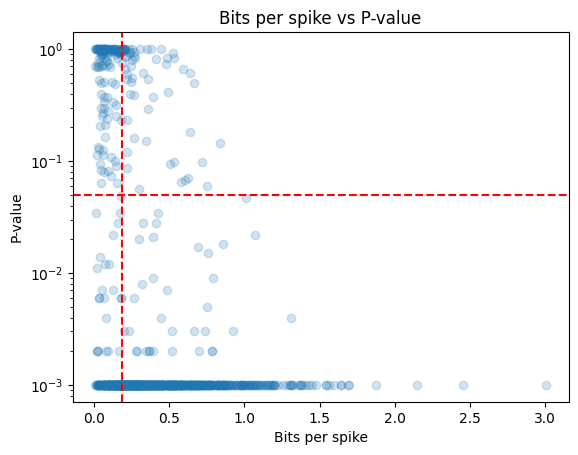

In [2]:
spatial_info_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Plot bits per spike against P-value
# Add small constant to avoid log(0)
spatial_info_all['p_value'] = spatial_info_all['p_value'] + 1e-3
plt.scatter(spatial_info_all['bits_per_spike'], spatial_info_all['p_value'], alpha = 0.2)
plt.xlabel('Bits per spike')
plt.ylabel('P-value')
plt.title('Bits per spike vs P-value')
plt.yscale('log')
plt.axhline(y = 0.05, color = 'r', linestyle = '--')
plt.axvline(x = abs_threshold, color = 'r', linestyle = '--')
plt.show()

In [3]:
# from scipy.io import savemat

# rate_maps_open_field_1 = rate_maps_all.to_dict()['open-field_1']
# rate_maps_open_field_2 = rate_maps_all.to_dict()['open-field_2']
# rate_maps_t_maze_1 = rate_maps_all.to_dict()['t-maze_1']
# rate_maps_t_maze_2 = rate_maps_all.to_dict()['t-maze_2']
# occupancy_maps_open_field_1 = occupancy_maps_all.to_dict()['open-field_1']
# occupancy_maps_open_field_2 = occupancy_maps_all.to_dict()['open-field_2']
# occupancy_maps_t_maze_1 = occupancy_maps_all.to_dict()['t-maze_1']
# occupancy_maps_t_maze_2 = occupancy_maps_all.to_dict()['t-maze_2']

# maps_list = [rate_maps_open_field_1, rate_maps_open_field_2, rate_maps_t_maze_1, rate_maps_t_maze_2,
#              occupancy_maps_open_field_1, occupancy_maps_open_field_2, occupancy_maps_t_maze_1, occupancy_maps_t_maze_2]

# # add letter to each value in dict keys to make them valid matlab field names
# for m in maps_list[0:4]:
#     keys = list(m.keys())
#     for k in keys:
#         m['a' + k] = m.pop(k)
# for m in maps_list[4:8]:
#     keys = list(m.keys())
#     for k in keys:
#         m['b' + k] = m.pop(k)

# savemat('rate_maps_open-field_1.mat', maps_list[0])
# savemat('rate_maps_open-field_2.mat', maps_list[1])
# savemat('rate_maps_t-maze_1.mat', maps_list[2])
# savemat('rate_maps_t-maze_2.mat', maps_list[3])
# savemat('occupancy_maps_open-field_1.mat', maps_list[4])
# savemat('occupancy_maps_open-field_2.mat', maps_list[5])
# savemat('occupancy_maps_t-maze_1.mat', maps_list[6])
# savemat('occupancy_maps_t-maze_2.mat', maps_list[7])

In [4]:
spatial_info_df =pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')
spatial_info_df.dropna()


,bits_per_spike,bits_per_sec,p_value,z_scoreage,age,z_score


## Spatial Information & Stats

ANOVA for bits per spike: F_onewayResult(statistic=1.177330224667898, pvalue=0.30876760941337306)
ANOVA for bits per sec: F_onewayResult(statistic=9.911038015659503, pvalue=5.769024995466646e-05)
ANOVA for bits per spike not significant, skipping Tukey HSD test
Tukey HSD for bits per sec: Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0  -0.0452 0.9126 -0.2223  0.1318  False
   1.0    3.0   0.2453 0.0026  0.0659  0.4246   True
   1.0    nan  -0.9061 0.0027 -1.5707 -0.2416   True
   2.0    3.0   0.2905 0.0002  0.1114  0.4696   True
   2.0    nan  -0.8609  0.005 -1.5254 -0.1964   True
   3.0    nan  -1.1514 0.0001 -1.8165 -0.4863   True
----------------------------------------------------


(0.0, 3.0)

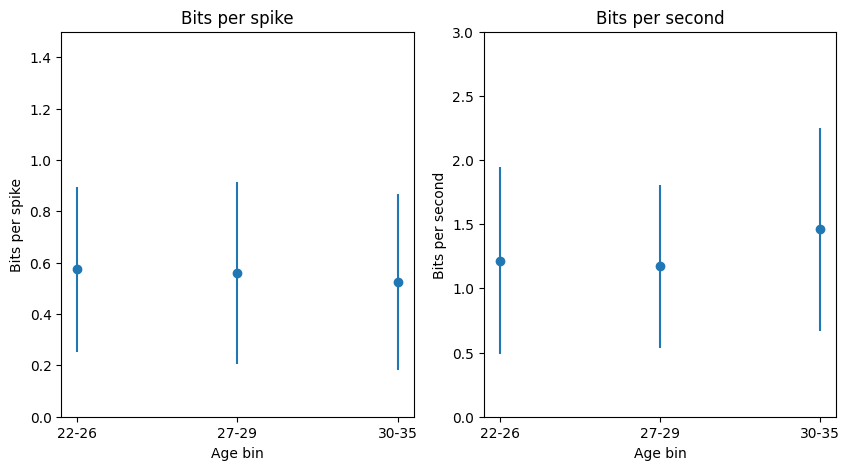

In [5]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set age bins
age_bins = [(22, 26), (27, 29), (30, 35)]

# Load pickled rate map data
rate_maps_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/rate_maps_all.pkl')
spatial_info_df = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Format spatial info dataframe
# spatial_info_df.dropna(inplace = True)
spatial_info_df.reset_index(inplace = True)
spatial_info_df = spatial_info_df.rename(columns = {'index': 'cell_id'})
spatial_info_df['trial_type'] = spatial_info_df['cell_id'].apply(lambda x: x.split('_')[-3])
spatial_info_df['age'] = spatial_info_df['age'].astype(int)

# Select only cells with p < 0.05 and spatial info > abs_threshold
spatial_info_df = spatial_info_df[spatial_info_df['p_value'] < 0.05]
spatial_info_df = spatial_info_df[spatial_info_df['bits_per_spike'] > abs_threshold]
# Make mask for significant cells
significant_cells = spatial_info_df['cell_id']

# Group by age bin
spatial_info_df['age_bin'] = pd.cut(spatial_info_df['age'], bins = [22, 26, 29, 35], labels = ['22-26', '27-29', '30-35'])
# Convert 'age_bin' column to categorical data type
spatial_info_df['age_bin'] = pd.Categorical(spatial_info_df['age_bin'], categories=['22-26', '27-29', '30-35'], ordered=True)

# Calculate mean and std of bits_per_spike and bits_per_sec
spatial_info_df_stats = spatial_info_df.groupby('age_bin').agg({'bits_per_spike': ['mean', 'std'], 'bits_per_sec': ['mean', 'std']}).reset_index()

# Perform ANOVA on age bin and bits per spike
anova_bits_per_spike = stats.f_oneway(spatial_info_df[spatial_info_df['age_bin'] == '22-26']['bits_per_spike'],
                       spatial_info_df[spatial_info_df['age_bin'] == '27-29']['bits_per_spike'],
                       spatial_info_df[spatial_info_df['age_bin'] == '30-35']['bits_per_spike'])
print(f'ANOVA for bits per spike: {anova_bits_per_spike}')

# Perform ANOVA on age bin and bits per sec
anova_bits_per_sec = stats.f_oneway(spatial_info_df[spatial_info_df['age_bin'] == '22-26']['bits_per_sec'],
                       spatial_info_df[spatial_info_df['age_bin'] == '27-29']['bits_per_sec'],
                       spatial_info_df[spatial_info_df['age_bin'] == '30-35']['bits_per_sec'])
print(f'ANOVA for bits per sec: {anova_bits_per_sec}')

# Replace string age bins with integers
age_bin_mapping = {'22-26': 1, '27-29': 2, '30-35': 3}
spatial_info_df['age_bin'] = spatial_info_df['age_bin'].replace(age_bin_mapping)

if anova_bits_per_spike[1] < 0.05:
    # Perform Tukey HSD test for bits per spike
    tukey_bits_per_spike = pairwise_tukeyhsd(spatial_info_df['bits_per_spike'].astype(float), spatial_info_df['age_bin'])
    print(f'Tukey HSD for bits per spike: {tukey_bits_per_spike}')
else:
    print('ANOVA for bits per spike not significant, skipping Tukey HSD test')

# if p < 0.05, perform Tukey HSD test
if anova_bits_per_sec[1] < 0.05:
    # Perform Tukey HSD test for bits per sec
    tukey_bits_per_sec = pairwise_tukeyhsd(spatial_info_df['bits_per_sec'].astype(float), spatial_info_df['age_bin'])
    print(f'Tukey HSD for bits per sec: {tukey_bits_per_sec}')
else:
    print('ANOVA for bits per sec not significant, skipping Tukey HSD test')

# Plot bits_per_spike and bits_per_sec for each age bin
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].errorbar(x = spatial_info_df_stats['age_bin'], y = spatial_info_df_stats['bits_per_spike']['mean'], yerr = spatial_info_df_stats['bits_per_spike']['std'], fmt = 'o')
axes[0].set_title('Bits per spike')
axes[0].set_xlabel('Age bin')
axes[0].set_ylabel('Bits per spike')
axes[0].set_ylim(0, 1.5)

axes[1].errorbar(x = spatial_info_df_stats['age_bin'], y = spatial_info_df_stats['bits_per_sec']['mean'], yerr = spatial_info_df_stats['bits_per_sec']['std'], fmt = 'o')
axes[1].set_title('Bits per second')
axes[1].set_xlabel('Age bin')
axes[1].set_ylabel('Bits per second')
axes[1].set_ylim(0, 3)


## Spatial Correlation & Stats

ANOVA for spatial_correlation_open-field: F_onewayResult(statistic=23.40805028628364, pvalue=8.364074381073873e-10)
ANOVA for spatial_correlation_t-maze: F_onewayResult(statistic=7.437398417522424, pvalue=0.0007787474299778983)
ANOVA significant, performing Tukey HSD test
Tukey HSD for spatial_correlation_open-field: Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0   0.0756 0.3059  -0.037  0.1883  False
   1.0    3.0  -0.2179    0.0 -0.3338 -0.1021   True
   1.0    nan   0.0638 0.9725 -0.3169  0.4446  False
   2.0    3.0  -0.2936    0.0 -0.4081  -0.179   True
   2.0    nan  -0.0118 0.9998 -0.3922  0.3686  False
   3.0    nan   0.2818 0.2251 -0.0995  0.6631  False
----------------------------------------------------
Tukey HSD for bits spatial_correlation_t-maze: Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  rejec

(0.0, 1.0)

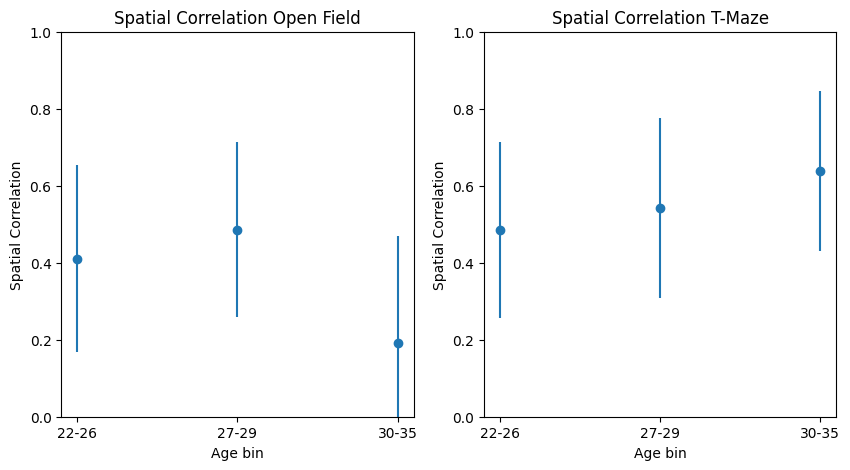

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from spatial_correlation import spatial_correlation
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

age_bins = [(22, 26), (27, 29), (30, 35)]

# Load pickled rate map data
rate_maps_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/rate_maps_all.pkl')

# # Drop non-significant cells using mask
significant_sessions = significant_cells.apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1] + '_' + x.split('_')[5]).unique()
rate_maps_all = rate_maps_all[rate_maps_all.index.isin(significant_sessions)]
# # Drop all rate map indices containing r1364
# rate_maps_all = rate_maps_all[rate_maps_all.index.str.contains('r1432')]

# Calculate spatial correlation for each cluster across both trial types
for trial_type in ['open-field', 't-maze']:
    rate_maps_correlation = rate_maps_all[[f'{trial_type}_1', f'{trial_type}_2']].dropna()

    spatial_correlations = spatial_correlation(rate_maps_correlation[f'{trial_type}_1'].to_list(), rate_maps_correlation[f'{trial_type}_2'].to_list())

    rate_maps_all.loc[rate_maps_correlation.index, f'spatial_correlation_{trial_type}'] = spatial_correlations

rate_maps_all

# Keep only age and spatial correlation columns
spatial_correlations = rate_maps_all[['age', 'spatial_correlation_open-field', 'spatial_correlation_t-maze']].dropna().copy()
# Convert age to int
spatial_correlations['age'] = spatial_correlations['age'].astype(int)

# Group by age bin
spatial_correlations['age_bin'] = pd.cut(spatial_correlations['age'], bins = [22, 26, 29, 35], labels = ['22-26', '27-29', '30-35'])
# Convert 'age_bin' column to categorical data type
spatial_correlations['age_bin'] = pd.Categorical(spatial_correlations['age_bin'], categories=['22-26', '27-29', '30-35'], ordered=True)

# Calculate mean and std of spatial info correlations
spatial_correlations_stats = spatial_correlations.groupby('age_bin').agg({'spatial_correlation_open-field': ['mean', 'std'], 'spatial_correlation_t-maze': ['mean', 'std']}).reset_index()

# Perform ANOVA on age bin and open field spatial correlation
anova_open_field = stats.f_oneway(spatial_correlations[spatial_correlations['age_bin'] == '22-26']['spatial_correlation_open-field'],
                       spatial_correlations[spatial_correlations['age_bin'] == '27-29']['spatial_correlation_open-field'],
                       spatial_correlations[spatial_correlations['age_bin'] == '30-35']['spatial_correlation_open-field'])
print(f'ANOVA for spatial_correlation_open-field: {anova_open_field}')

# Perform ANOVA on age bin and t-maze spatial correlation
anova_tmaze = stats.f_oneway(spatial_correlations[spatial_correlations['age_bin'] == '22-26']['spatial_correlation_t-maze'],
                       spatial_correlations[spatial_correlations['age_bin'] == '27-29']['spatial_correlation_t-maze'],
                       spatial_correlations[spatial_correlations['age_bin'] == '30-35']['spatial_correlation_t-maze'])
print(f'ANOVA for spatial_correlation_t-maze: {anova_tmaze}')

# Replace string age bins with integers
age_bin_mapping = {'22-26': 1, '27-29': 2, '30-35': 3}
spatial_correlations['age_bin'] = spatial_correlations['age_bin'].replace(age_bin_mapping)

# if p < 0.05, perform Tukey HSD test
if anova_open_field[1] < 0.05:
    print('ANOVA significant, performing Tukey HSD test')
    # Perform Tukey HSD test for open field spatial correlation
    tukey_open_field = pairwise_tukeyhsd(spatial_correlations['spatial_correlation_open-field'], spatial_correlations['age_bin'])
    print(f'Tukey HSD for spatial_correlation_open-field: {tukey_open_field}')
else:
    print('ANOVA for open field not significant, skipping Tukey HSD test')

if anova_tmaze[1] < 0.05:
    # Perform Tukey HSD test for t-maze spatial correlation
    tukey_tmaze = pairwise_tukeyhsd(spatial_correlations['spatial_correlation_t-maze'], spatial_correlations['age_bin'])
    print(f'Tukey HSD for bits spatial_correlation_t-maze: {tukey_tmaze}')
else:
    print('ANOVA for T-maze not significant, skipping Tukey HSD test')

# Plot spatial correlation for open field and t-maze for each age bin
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].errorbar(x = spatial_correlations_stats['age_bin'], y = spatial_correlations_stats['spatial_correlation_open-field']['mean'], yerr = spatial_correlations_stats['spatial_correlation_open-field']['std'], fmt = 'o')
axes[0].set_title('Spatial Correlation Open Field')
axes[0].set_xlabel('Age bin')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Spatial Correlation')

axes[1].errorbar(x = spatial_correlations_stats['age_bin'], y = spatial_correlations_stats['spatial_correlation_t-maze']['mean'], yerr = spatial_correlations_stats['spatial_correlation_t-maze']['std'], fmt = 'o')
axes[1].set_title('Spatial Correlation T-Maze')
axes[1].set_xlabel('Age bin')
axes[1].set_ylabel('Spatial Correlation')
axes[1].set_ylim(0, 1)

In [7]:
from session_utils import find_all_sessions
from ephys import *
import matplotlib.pyplot as plt

# Load all cells from phy with age
# Find all included sessions from Google sheet, with structure session_name: path
session_dict = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')
print(f'{len(session_dict.items())} sessions found')

cluster_info_all = pd.DataFrame()

for session, session_path in session_dict.items():
    
    # Create ephys object
    obj = ephys(recording_type = 'nexus', path = session_path)
    
    ## A. Load good cells from phy
    obj.load_spikes('good')
    
    # Get cluster info from phy
    cluster_info = obj.spike_data['cluster_info']

    cluster_info['session'] = session
    
    # Append session to cluster_info_all index
    cluster_info.index = cluster_info['session'] + '_' + cluster_info.index.astype(str)

    # Add age to cluster_info
    cluster_info['age'] = obj.age
    
    # Concat cluster info for all sessions
    cluster_info_all = pd.concat([cluster_info_all, cluster_info])

cluster_info_all

# Load all pyramidal cells
pyramidal_cells_df = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')
pyramidal_cells_df.dropna(inplace = True)

# Loop through rows and make a list of all included clusters
pyramidal_cells = []
for session, clusters in pyramidal_cells_df['clusters_inc'].items():
    try:
        for cluster in clusters:
            pyramidal_cells.append(f'{session}_{cluster}')
    except:
        pyramidal_cells.append(f'{session}_{clusters}')


# Load all place cells
place_cells_df = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_place_cells.pkl')
place_cells_df.dropna(inplace = True)

# Loop through rows and make a list of all included clusters
place_cells = []
for session, clusters in place_cells_df['clusters_inc'].items():
    try:
        for cluster in clusters:
            place_cells.append(f'{session}_{cluster}')
    except:
        place_cells.append(f'{session}_{clusters}')


# Make a boolean column in cluster_info_all for each cell type
cluster_info_all['pyramidal'] = cluster_info_all.index.isin(pyramidal_cells)
cluster_info_all['place_cell'] = cluster_info_all.index.isin(place_cells)
# Add column which is true for all cells
cluster_info_all['cell'] = True

cluster_info_all

57 sessions found


,%RPV,Amplitude,ContamPct,ISI_viol,KSLabel,RPV,amp,ch,depth,fr,group,n_spikes,sh,session,age,channel,pyramidal,place_cell,cell
230503_r1354_317,1.069947,5734.2,61.6,[0.25],mua,147,306.414825,39,-400.0,11.449047,good,13739,0,230503_r1354,23,NaN,False,False,True
230503_r1354_318,0.956275,11729.9,35.2,[0.26],mua,145,450.497223,42,-1200.0,12.635702,good,15163,0,230503_r1354,23,NaN,False,False,True
230503_r1354_322,0.785964,7869.6,29.6,[0.22],mua,99,409.181946,58,-100.0,10.496557,good,12596,0,230503_r1354,23,NaN,False,False,True
230503_r1354_324,0.946767,5877.5,17.1,[0.15],mua,106,418.411591,37,-200.0,9.329903,good,11196,0,230503_r1354,23,NaN,False,False,True
230503_r1354_328,0.277489,5734.2,61.6,[0.36],mua,8,306.414825,39,-400.0,2.402475,good,2883,0,230503_r1354,23,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231101_r1428_299,1.298701,4416.2,167.3,[0.79],mua,158,329.746246,60,500.0,4.054995,good,12166,0,231101_r1428,34,NaN,False,False,True
231101_r1428_301,1.120254,3049.6,90.0,[0.67],mua,162,241.750687,63,90.0,4.819932,good,14461,0,231101_r1428,34,NaN,True,True,True
231101_r1428_309,0.805306,4458.6,180.0,[0.5],mua,85,341.514160,35,0.0,3.518040,good,10555,0,231101_r1428,34,NaN,True,True,True
231101_r1428_311,1.992564,6119.0,150.6,1,mua,209,373.888184,54,-900.0,3.496042,good,10489,0,231101_r1428,34,NaN,False,False,True


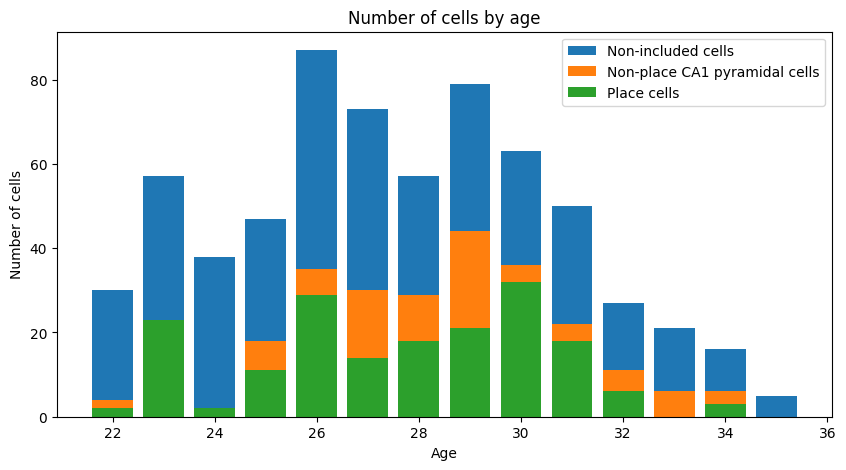

In [11]:
# Plot a stacked bar chart of all, pyramidal and place cells by age with one bar per day
# Group by age and count number of cells
cell_counts = cluster_info_all.groupby('age').agg({'cell': 'sum', 'pyramidal': 'sum', 'place_cell': 'sum'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(cell_counts['age'], cell_counts['cell'], label = 'Non-included cells')
ax.bar(cell_counts['age'], cell_counts['pyramidal'], label = 'Non-place CA1 pyramidal cells')
ax.bar(cell_counts['age'], cell_counts['place_cell'], label = 'Place cells')
ax.set_xlabel('Age')
ax.set_ylabel('Number of cells')
ax.set_title('Number of cells by age')
ax.legend()
plt.show()